MODEL TRAINING AND TESTING

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random
import os

In [2]:
# File path

result_dir = os.path.join('..', 'Outputs', 'ALZ_results')
target_dir = os.path.join('..', 'Final Datasets', 'ALZ_final')
raw_file_dir = os.path.join('..', 'Raw_Datasets', 'ALZ_data')

# Final File path 
snp_file = os.path.join(raw_file_dir, 'ALZ_top2000_cleaned.csv')
pheno_final_extended = os.path.join(target_dir, 'ALZ_aligned_phenotypes_final_extended.csv')
pheno_final_path = os.path.join(target_dir, 'ALZ_aligned_phenotypes_final.csv') 
geno_final_path = os.path.join(target_dir, 'ALZ_aligned_genotypes_final.csv')
logreg_model = os.path.join(result_dir, 'ALZ_selectKbest_logreg_model.joblib')
logreg_coeff = os.path.join(result_dir, 'logreg_selectKbest_coefficients.csv')
logreg_model_AS = os.path.join(result_dir, 'ALZ_selectKbest_logreg_model_AgeSex.joblib')
logreg_coeff_AS = os.path.join(result_dir, 'logreg_selectKbest_coefficients_AgeSex.csv')
model_perf = os.path.join(result_dir, 'ALZ_selectKbest_model_performance.png')
model_perf_AS = os.path.join(result_dir, 'ALZ_selectKbest_model_performance_AgeSex.png')
cf_matrix = os.path.join(result_dir, 'ALZ_confusion_matrix.png')
prs_csv = os.path.join(result_dir, 'ALZ_prs_scores.csv')
prs_png = os.path.join(result_dir, 'ALZ_PRS_distribution_fixed.png')

In [3]:
# Loading the data
X = pd.read_csv(geno_final_path, index_col=0)
y = pd.read_csv(pheno_final_path).set_index("sample_id")["label"]

#Aligning the samples
common = X.index.intersection(y.index)
X = X.loc[common]
y = y.loc[common]

gwas = pd.read_csv(snp_file)
gwas_filtered = gwas[gwas["p_value"]<1e-5]
gwas_filtered["chr_pos"] = gwas_filtered["chrom"].astype(str) + "_" + gwas_filtered["pos"].astype(str)
gwas_snps = gwas_filtered["chr_pos"]

X_gwas = X.loc[:, X.columns.intersection(gwas_snps)]
print(f"SNPs after gwas p-value filtering : {X_gwas.shape[1]}")

# Selecting top SNPs using ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=min(50, X_gwas.shape[1]))
X_selected = selector.fit_transform(X_gwas, y)

# Retaining column names
selected_snps = X_gwas.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X_gwas.index, columns=selected_snps)

SNPs after gwas p-value filtering : 1314


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.20, stratify=y, random_state=42
)

In [5]:
# Train Logistic Regression with L1 penalty
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    class_weight='balanced',
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.683
Test AUC: 0.647

Accuracy (threshold 0.5): 0.653
Sensitivity (Recall): 0.580
Specificity: 0.661

Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       451
           1       0.16      0.58      0.25        50

    accuracy                           0.65       501
   macro avg       0.55      0.62      0.51       501
weighted avg       0.86      0.65      0.72       501



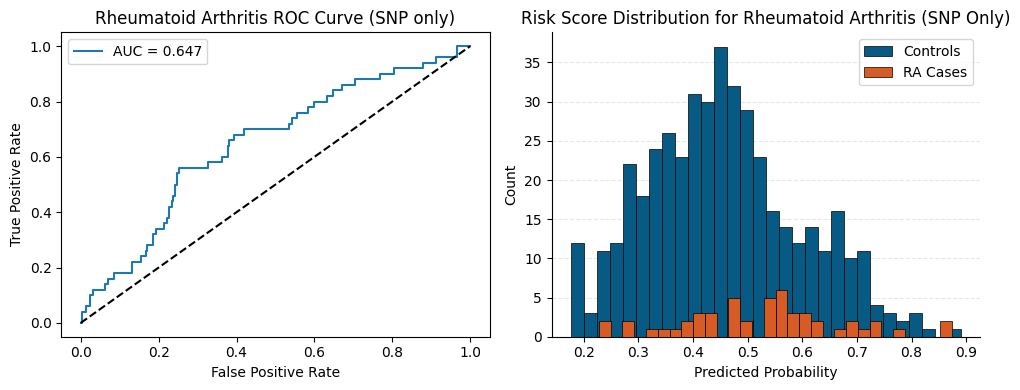


Confusion Matrix (threshold = 0.5):
[[298 153]
 [ 21  29]]


In [6]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Rheumatoid Arthritis ROC Curve (SNP only)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=2)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="RA Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=3)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for Rheumatoid Arthritis (SNP Only)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))

In [29]:
#Taking only Age And Sex

# Loading phenotypes 
df = pd.read_csv(pheno_final_extended).set_index("sample_id")

# Define age+sex as features, label as target
df["sex"] = df["sex"].map({"M":0, "F":1})
X_age_sex = df[["age", "sex"]]
y = df["label"]

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_age_sex, y, stratify=y, test_size=0.10, random_state=42
)

# Train and Evaluate
model = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='saga', max_iter=10000, n_jobs=2, random_state=42)
model.fit(X_train, y_train)

auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"Age + Sex Only AUC: {auc:.3f}")

Age + Sex Only AUC: 0.500


In [12]:
# Creating the model to take age + sex + genetics as features

X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_extended).set_index("sample_id")

common = X.index.intersection(phenos.index)
X = X.loc[common]
phenos = phenos.loc[common]

phenos["sex_bin"] = phenos["sex"].map({"M":0, "F":1})

y = phenos["label"]
age = phenos["age"]
sex = phenos["sex_bin"]

In [13]:
gwas = pd.read_csv(snp_file)
gwas["chr_pos"] = gwas["chrom"].astype(str) + "_" + gwas["pos"].astype(str)
gwas_snps = gwas[gwas["p_value"]<1e-5]["chr_pos"]
X_gwas = X.loc[:, X.columns.intersection(gwas_snps)]
print(f"GWAS-filtered SNPs: {X_gwas.shape[1]}")

selector = SelectKBest(score_func=f_classif, k=min(50, X_gwas.shape[1]))
X_selected = selector.fit_transform(X_gwas, y)
selected_snps = X_gwas.columns[selector.get_support()]
X_selected_df = pd.DataFrame(X_selected, index=X_gwas.index, columns=selected_snps)

X_selected_df["age"] = age
X_selected_df["sex"] = sex

GWAS-filtered SNPs: 1314


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df, y, test_size=0.20, stratify=y, random_state=42
)

In [15]:
print("Training LogisticRegressionCV...")
logreg = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty='l1',
    solver='saga',
    scoring='roc_auc',
    max_iter=10000,
    class_weight='balanced',
    n_jobs=2,
    random_state=42
).fit(X_train, y_train)

Training LogisticRegressionCV...


Train AUC: 0.684
Test AUC: 0.651

Accuracy (threshold 0.5): 0.649
Sensitivity (Recall): 0.600
Specificity: 0.654

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.65      0.77       451
           1       0.16      0.60      0.25        50

    accuracy                           0.65       501
   macro avg       0.55      0.63      0.51       501
weighted avg       0.86      0.65      0.72       501



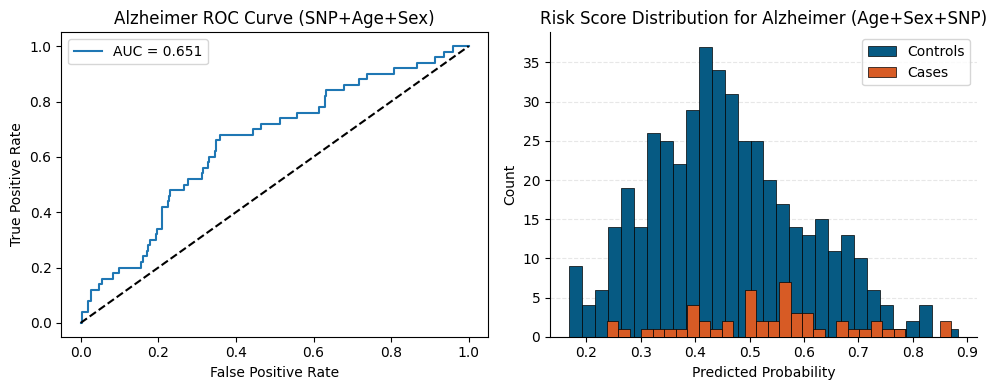


Confusion Matrix (threshold = 0.5):
[[295 156]
 [ 20  30]]


In [18]:
# Prediction and evaluation
y_pred_prob_train = logreg.predict_proba(X_train)[:, 1]
y_pred_prob = logreg.predict_proba(X_test)[:, 1]
train_auc = roc_auc_score(y_train, y_pred_prob_train)
test_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Train AUC: {train_auc:.3f}")
print(f"Test AUC: {test_auc:.3f}")

y_pred_binary = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"\nAccuracy (threshold 0.5): {accuracy:.3f}")

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")

# Step 3: Optional detailed report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_binary))

# Step 7: Save model and coefficients
joblib.dump(logreg, logreg_model_AS)
pd.Series(logreg.coef_.flatten(), index=X_selected_df.columns, name="coefficients")\
  .to_csv(logreg_coeff_AS)

# Step 8: Visualize ROC and Risk Score Distribution
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 4))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Alzheimer ROC Curve (SNP+Age+Sex)")
plt.legend()

# Risk Score Histogram
plt.subplot(1, 2, 2)
plt.hist(y_pred_prob[y_test == 0], bins=30, alpha=1, label="Controls", color="#065a83", edgecolor='black', linewidth=0.5, zorder=2)
plt.hist(y_pred_prob[y_test == 1], bins=30, alpha=1, label="Cases", color="#d75b25", edgecolor='black', linewidth=0.5, zorder=3)
plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Risk Score Distribution for Alzheimer (Age+Sex+SNP)")
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(model_perf_AS, dpi=500, bbox_inches='tight')
plt.show()

# Step 9: Confusion Matrix
print("\nConfusion Matrix (threshold = 0.5):")
print(confusion_matrix(y_test, y_pred_prob > 0.5))

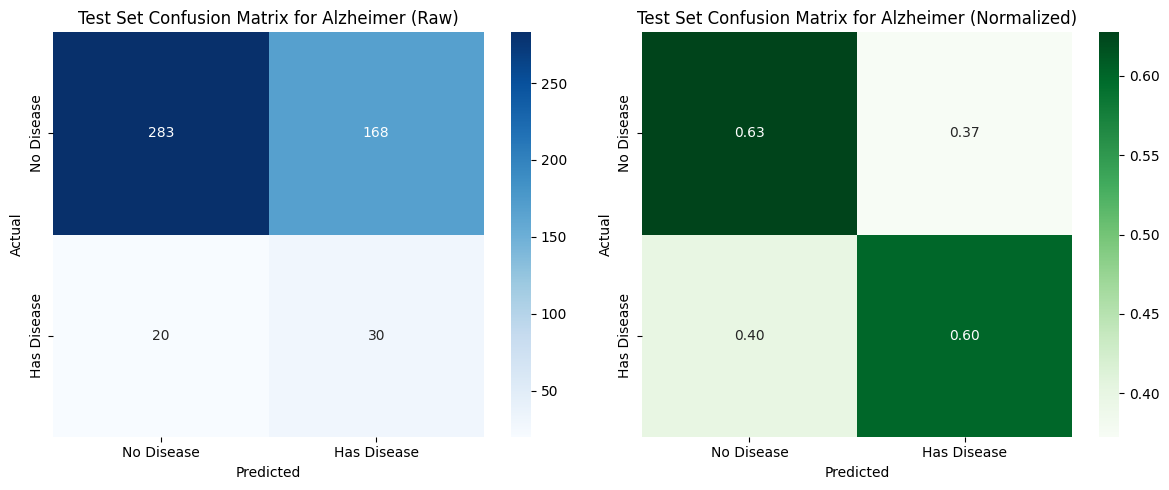

In [35]:
# Predicted labels using threshold 0.5
y_pred_label = (y_pred_prob > 0.1).astype(int)

# Confusion Matrix - Raw
cm_raw = confusion_matrix(y_test, y_pred_label)

# Confusion Matrix - Normalized
cm_normalized = confusion_matrix(y_test, y_pred_label, normalize='true')

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Raw Confusion Matrix
sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Test Set Confusion Matrix for Alzheimer (Raw)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['No Disease', 'Has Disease'])
axes[0].set_yticklabels(['No Disease', 'Has Disease'])

# Normalized Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', ax=axes[1])
axes[1].set_title('Test Set Confusion Matrix for Alzheimer (Normalized)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['No Disease', 'Has Disease'])
axes[1].set_yticklabels(['No Disease', 'Has Disease'])

plt.tight_layout()
plt.savefig(cf_matrix, dpi=300)
plt.show()



SNPs in coefficients file: 48
Overlap in X genotype matrix: 48


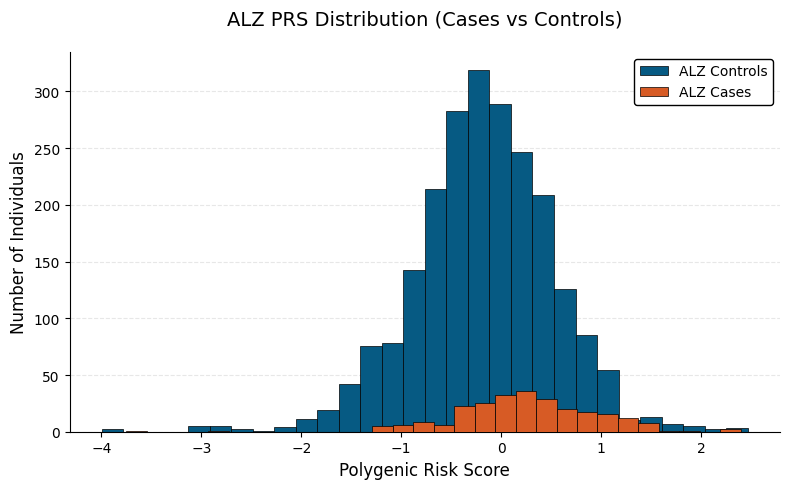

In [36]:
X = pd.read_csv(geno_final_path, index_col=0)
phenos = pd.read_csv(pheno_final_path).set_index("sample_id")

model = joblib.load(logreg_model)
coef = pd.read_csv(logreg_coeff, index_col=0)
coef = coef.squeeze()

selected_snps = coef.index.tolist()
X_prs = X[selected_snps]

prs_scores = X_prs.dot(coef)
prs_df = phenos[["label"]].copy()
prs_df["PRS"] = prs_scores

print("\nSNPs in coefficients file:", len(selected_snps))
print("Overlap in X genotype matrix:", X.columns.intersection(selected_snps).shape[0])

prs_df.to_csv(prs_csv)


#Histogram plotting
case_color = "#d75b25"      
control_color = "#065a83"    

plt.figure(figsize=(8, 5), dpi=100)

plt.hist(
    prs_df[prs_df["label"] == 0]["PRS"],
    bins=30,
    alpha=1,
    label="ALZ Controls",
    color=control_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=2
)

plt.hist(
    prs_df[prs_df["label"] == 1]["PRS"],
    bins=30,
    alpha=1,
    label="ALZ Cases",
    color=case_color,
    edgecolor='black',
    linewidth=0.5,
    zorder=3
)

plt.grid(axis='y', alpha=0.3, linestyle='--', zorder=1)

plt.title("ALZ PRS Distribution (Cases vs Controls)", fontsize=14, pad=20)
plt.xlabel("Polygenic Risk Score", fontsize=12)
plt.ylabel("Number of Individuals", fontsize=12)
plt.legend(framealpha=1, edgecolor='black')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(prs_png, dpi=500, bbox_inches='tight')
plt.show()

In [37]:
# Top 10% threshold taken
prs_threshold = prs_df["PRS"].quantile(0.90)

# Counting individuals above it
high_risk = prs_df[prs_df["PRS"] >= prs_threshold]

# Splitting by label
high_risk_cases = high_risk[high_risk["label"] == 1].shape[0]
high_risk_controls = high_risk[high_risk["label"] == 0].shape[0]

print(f"Top 10% PRS threshold: {prs_threshold:.3f}")
print(f"ALZ Cases in top 10%: {high_risk_cases}")
print(f"Controls in top 10%: {high_risk_controls}")

Top 10% PRS threshold: 0.723
ALZ Cases in top 10%: 61
Controls in top 10%: 190


In [38]:
model = joblib.load(logreg_model)  

# Best C chosen by CV
C_star = model.C_[0]               
lambda_star = 1 / C_star           

print(f"Best C (C*): {C_star}")
print(f"Regularization Strength λ* = {lambda_star:.4e}")

Best C (C*): 21.54434690031882
Regularization Strength λ* = 4.6416e-02
